In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/tguethle/Documents/spi/Master_Thesis/main_files'))


import numpy as np
import astropy.io.fits as fits
from astropy.table import Table
from astromodels import Powerlaw, PointSource, SpectralComponent
import astropy.time as at
from datetime import datetime
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum, MultinestClusterFit
from RebinningFunctions import spimodfit_binning_SE, log_binning_function_for_x_number_of_bins, no_rebinning #, rebin_data_exp_50
from PointingClusters import PointingClusters, save_clusters, load_clusters
from ModelSources import *
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib

18:17:41 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=181545;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=256697;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=64700;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=848784;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=871866;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=707192;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

18:17:42 INFO      Starting 3ML!                                                                     ]8;id=471555;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=245517;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#31\31]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=568355;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=36539;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=120891;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=866229;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

18:17:43 WARNING   PyGMO is not available                                                      ]8;id=789909;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=184351;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

18:17:43 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=273423;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=655845;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#79\79]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=304254;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=519870;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=313942;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=695099;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=93362;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=277515;file:///home/tguethle/.opt/conda/envs/spi39/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

Using the irfs that are valid between Start and 03/07/06 06:00:00 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 03/07/06 06:00:00 and 04/07/17 08:20:06 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 09/02/19 09:59:57 and 10/05/27 12:45:00 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)


Compare the generated counts of pyspi with the output file from Spimodfit. Apperantly the convsky_output file contains these expacted counts

## Spimodfit output

parameters for this spimodfit run 
index = -2
K = 7e-2
piv = 100

In [2]:
# take a look at the response of spimodfit
spimodfit_path_1160 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
spimodfit_path_41 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_new/"

response_name = "convolved_sky_images.fits"

with fits.open(spimodfit_path_41 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)
counts_41 = t["COUNTS"]
err_41 = np.array(t["STAT_ERR"])

with fits.open(spimodfit_path_1160 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)


counts_1160 = t["COUNTS"]
err_1160 = np.array(t["STAT_ERR"])

spimodfit_counts_41, spimodfit_counts_1160 = np.array(counts_41), np.array(counts_1160)



In [21]:
# take a look at the response of spimodfit
spimodfit_path_1160 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
spimodfit_path_41 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_normal_new/"

response_name = "convolved_sky_images.fits"

with fits.open(spimodfit_path_41 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)
counts_41 = t["COUNTS"]
err_41_low_K = np.array(t["STAT_ERR"])



spimodfit_counts_41_low_K = np.array(counts_41)

In [4]:
spimodfit_counts_41_low_K.shape

(779, 41)

plot the counts for different detectors of one pointing. For now plot with only one energy bin

## Pyspi

In [3]:
# defining the source
K = 7e-2
ra, dec = 10, -40
index_pl = -2
piv = 100
# ra, dec = 155., 75.
# K, piv, index = 3e-3, 40, -1
data_path = '/home/tguethle/Documents/spi/Master_Thesis/main_files/sim_source_real_bkg/bright_100_new/0374'
orig_data_path_1160 = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center_small_bins'
orig_data_path_41 = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center'
# Define  Spectrum
def create_counts(orig_data_path, K=7e-2):
    print(f"Using k = {K}")
    pl = Powerlaw()
    pl.piv = piv
    pl.K = K
    pl.index = index_pl
    component1 = SpectralComponent("pl", shape=pl)
    source = PointSource("Test", ra=ra, dec=dec, components=[component1])

    #emod = np.geomspace(18, 2000, 200)
    emod = np.arange(20, 600.5, 0.5)
    spec = source(emod)
    spec_binned = powerlaw_binned_spectrum(emod, spec)


    # Energy Bins
    with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

        t = Table.read(file[1])
        energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
        print(f'Number of energy bins: {len(energy_bins)-1}')
    # Pointings and Start Times
    with fits.open(f"{orig_data_path}/pointing.fits") as file:
        t = Table.read(file[1])
        
        pointings = np.array(t["PTID_SPI"])
        
        time_start = np.array(t["TSTART"]) + 2451544.5
        time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
        time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


    # Time Elapsed
    # det=i, pointing_index=j : index = j*85 + i
    with fits.open(f"{orig_data_path}/dead_time.fits") as file:
        
        t = Table.read(file[1])
        time_elapsed = np.array(t["LIVETIME"])

    # Generate Source Counts

    assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
    version = find_response_version(time_start[0])
    rsp_base = ResponseDataRMF.from_version(version)

    source_counts = np.zeros((len(pointings)*85, len(energy_bins)-1), dtype=np.uint32)
    np_source_counts = np.zeros((len(pointings)*19, len(energy_bins)-1), dtype=np.uint32)

    for p_i, pointing in enumerate(pointings):
        
        time = time_start[p_i]
        dets = get_live_dets(time=time, event_types=["single"])
        
        rmfs = []
        for d in dets:
            rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
            
        sds = np.empty(0)
        for d in range(len(dets)):
            sd = SPIDRM(rmfs[d], ra, dec)
            sds = np.append(sds, sd.matrix.T)
        resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))
        
        count_rates = np.dot(spec_binned, resp_mat)
        
        for d_i, d in enumerate(dets):
            index = p_i * 85 + d
            counts_index = p_i * 19 + d
            source_counts[index,:] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])
            np_source_counts[counts_index,:] = count_rates[d_i,:] * time_elapsed[index]

    with fits.open(f"{orig_data_path}/evts_det_spec_orig.fits") as file:
        t = Table.read(file[1])
        
        counts = t
        

    total_counts = counts["COUNTS"] + source_counts

    return source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat


In [32]:
# source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = create_counts(orig_data_path_41)

In [61]:
res_41 = create_counts(orig_data_path_41)

res_41_low_K = create_counts(orig_data_path_41, K=7e-4)
# res_1160 = create_counts(orig_data_path_1160)

Using k = 0.07
Number of energy bins: 41
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Using k = 0.0007
Number of energy bins: 41
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)


In [8]:
bin_widths = energy_bins[1:] - energy_bins[:-1]
bin_widths

NameError: name 'energy_bins' is not defined

In [105]:
pyspi_counts_41 = np.array(res_41[0], dtype=np.float64)
pyspi_counts_41_low_K = np.array(res_41_low_K[0], dtype=np.float64)

# np.save("pyspi_counts_41.npy", pyspi_counts_41)
# np.save("pyspi_counts_41_low_K.npy", pyspi_counts_41_low_K)

In [6]:
pyspi_counts_41 = np.load("pyspi_counts_41.npy")
pyspi_counts_41_low_K = np.load("pyspi_counts_41_low_K.npy")


In [7]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

def divide_by_mean(arr):
    mean = np.nanmean(arr, axis=0)
    return arr / mean

(array([ 0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  4,  6,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  9,  9,  9, 10, 10, 11, 11, 13, 14, 14,
       16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18]), array([39, 37, 38, 39,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 39, 39, 39, 32, 33, 34,
       36, 37, 38, 39, 40, 38, 39, 37, 39, 40, 36, 39, 39, 40, 39, 36, 37,
       37, 38, 39,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38,

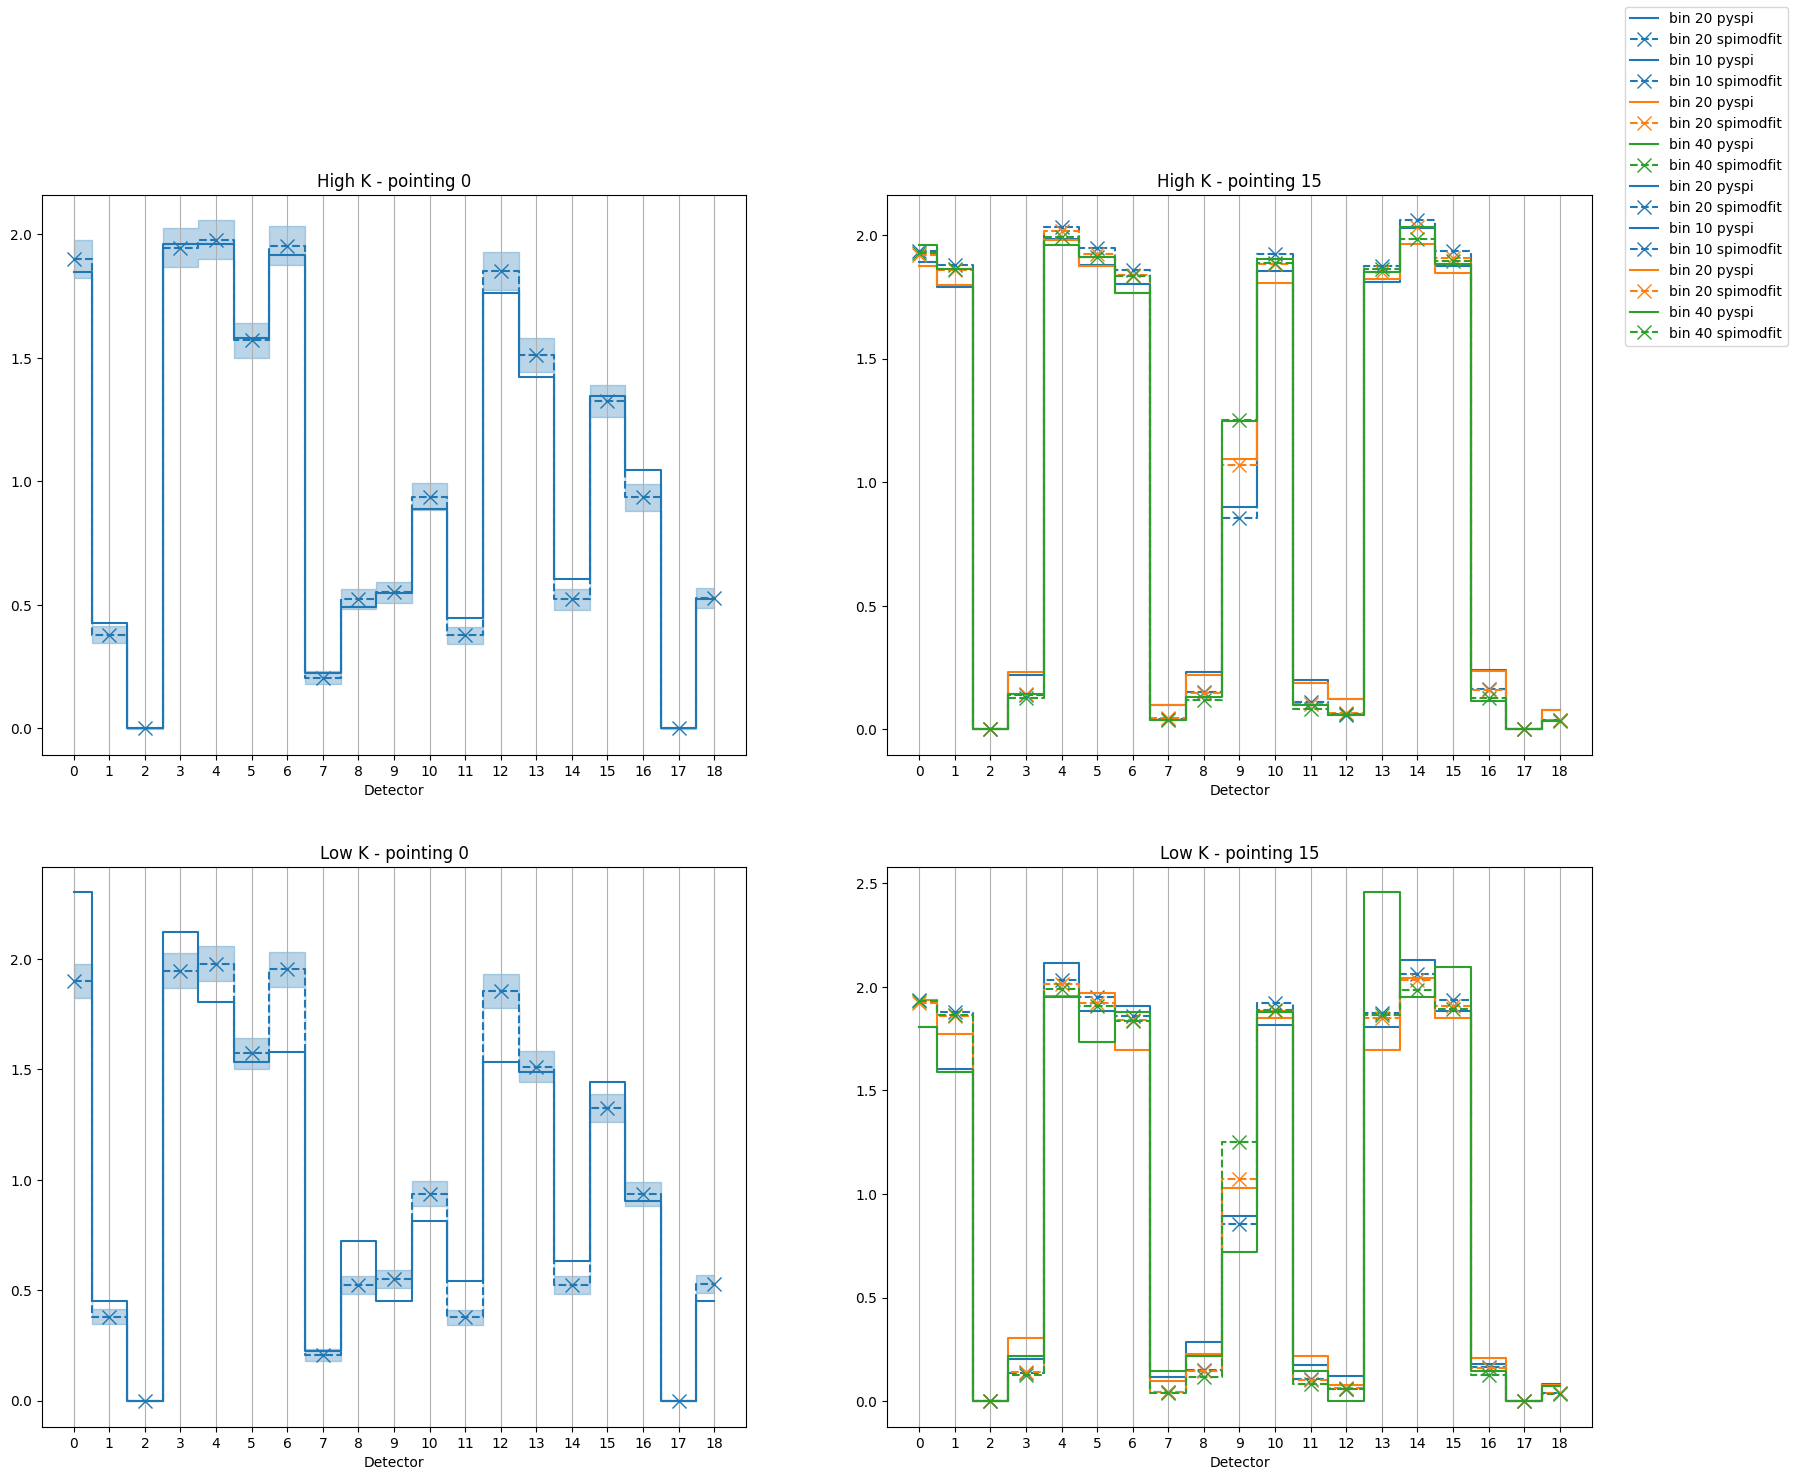

In [8]:
%matplotlib inline

pointing_id = (0,15)

# load data for high K
smf_detector_counts, smf_detector_counts_2 = [spimodfit_counts_41[(id * 19):(id +1) * 19] for id in pointing_id]
pyspi_detector_counts, pyspi_detector_counts_2 = [pyspi_counts_41[(id * 85):(id * 85) + 19] for id in pointing_id]

e1, e2 =  [err_41[(id * 19):(id +1) * 19] for id in pointing_id]
e1, e2 = e1 / np.nanmean(smf_detector_counts, axis=0), e2 / np.nanmean(smf_detector_counts_2, axis=0)


smf_detector_counts, smf_detector_counts_2 = divide_by_mean(smf_detector_counts), divide_by_mean(smf_detector_counts_2)
pyspi_detector_counts, pyspi_detector_counts_2 = divide_by_mean(pyspi_detector_counts), divide_by_mean(pyspi_detector_counts_2)

# load data for low K
smf_detector_counts_low_K, smf_detector_counts_2_low_K = [spimodfit_counts_41_low_K[(id * 19):(id +1) * 19] for id in pointing_id]
pyspi_detector_counts_low_K, pyspi_detector_counts_2_low_K = [pyspi_counts_41_low_K[(id * 85):(id * 85) + 19] for id in pointing_id]

e1_low_K, e2_low_K =  [err_41_low_K[(id * 19):(id +1) * 19] for id in pointing_id]
e1_low_K, e2_low_K = e1_low_K / np.nanmean(smf_detector_counts_low_K, axis=0), e2_low_K / np.nanmean(smf_detector_counts_2_low_K, axis=0)

smf_detector_counts_low_K, smf_detector_counts_2_low_K = divide_by_mean(smf_detector_counts_low_K), divide_by_mean(smf_detector_counts_2_low_K)
pyspi_detector_counts_low_K, pyspi_detector_counts_2_low_K = divide_by_mean(pyspi_detector_counts_low_K), divide_by_mean(pyspi_detector_counts_2_low_K)


# somehow deal with the errors


dets = np.arange(19)

c = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18"]

print(np.where(pyspi_detector_counts_low_K == 0))

fig, ((ax, ax2), (ax12, ax22)) = plt.subplots(2, 2, figsize=(20, 16))
# ax.plot(dets, smf_detector_counts[:,0], label="bin 0", c=c[0], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,5], label="bin 5", c=c[1], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,20], label="bin 20", c=c[2], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,35], label="bin 35", c=c[3], linestyle="-")

for a in (ax, ax2, ax12, ax22):
    a.set_xticks(dets)

    a.grid(axis="x")
    a.set_xlabel("Detector")

ax.set_title(f"High Flux, K=7e-2 - pointing {pointing_id[0]}")
ax2.set_title(f"High Flux, K=7e-2 - pointing {pointing_id[1]}")
ax12.set_title(f"Low Flux, K=7e-4 - pointing {pointing_id[0]}")
ax22.set_title(f"Low Flux, K=7e-4 - pointing {pointing_id[1]}")

for bin, color in zip((20,), c):
    ax.step(dets, pyspi_detector_counts[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax.step(dets, smf_detector_counts[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)

    # show spimodfit errors
    ax.fill_between(dets, smf_detector_counts[:,bin] - e1[:,bin], smf_detector_counts[:,bin] + e1[:,bin], color=color, alpha=0.3, step="mid")
    ax12.fill_between(dets, smf_detector_counts_low_K[:,bin] - e1_low_K[:,bin], smf_detector_counts_low_K[:,bin] + e1_low_K[:,bin], color=color, alpha=0.3, step="mid")


    ax12.step(dets, pyspi_detector_counts_low_K[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax12.step(dets, smf_detector_counts_low_K[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)


for bin, color in zip((10,20,40), c):
    ax2.step(dets, pyspi_detector_counts_2[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax2.step(dets, smf_detector_counts_2[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)
    ax22.step(dets, pyspi_detector_counts_2_low_K[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax22.step(dets, smf_detector_counts_2_low_K[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)


# ax.plot(dets, pyspi_detector_counts[:,0], label="bin 0", c=c[0], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,5], label="bin 5", c=c[1], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,20], label="bin 20", c=c[2], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,35], label="bin 35", c=c[3], linestyle="--")


fig.legend()



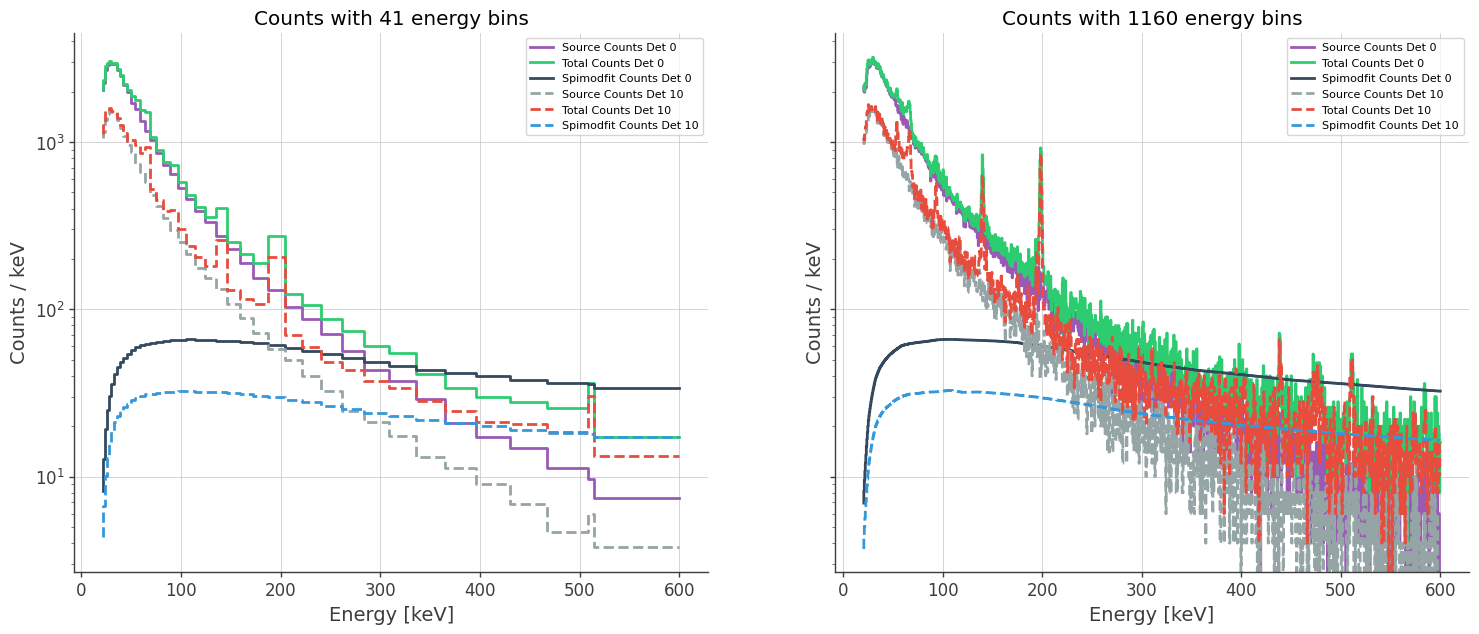

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for i, res, spimodfit_c in zip((0,1), (res_41, res_1160), (spimodfit_counts_41, spimodfit_counts_1160)):
    source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = res
    bin_widths = energy_bins[1:] - energy_bins[:-1]
    index = 0
    for index, line in zip([0, 10], ("solid", "dashed")):
        ax[i].step(energy_bins[1:], source_counts[index] / bin_widths, where='pre', label=f'Source Counts Det {index}', linestyle=line)
        ax[i].step(energy_bins[1:], total_counts[index] / bin_widths, where='pre', label=f'Total Counts Det {index}', linestyle=line)
        ax[i].step(energy_bins[1:], spimodfit_c[index] / bin_widths, where='pre', label=f'Spimodfit Counts Det {index}', linestyle=line)
        ax[i].set_title(f"Counts with {len(energy_bins)-1} energy bins")
    ax[i].set_yscale('log')
    ax[i].grid()
    
    ax[i].set_xlabel("Energy [keV]")
    ax[i].set_ylabel("Counts / keV")
    ax[i].legend()

# fig.savefig("Counts_comparison.pdf")

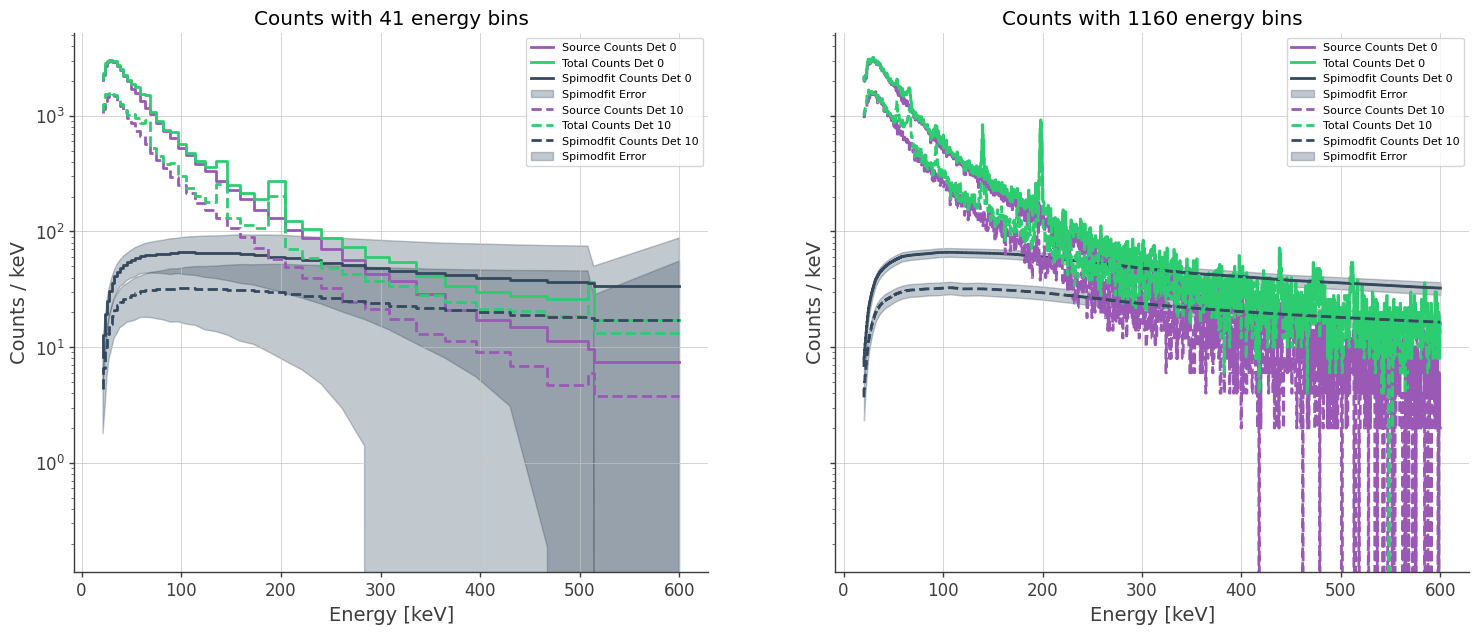

In [32]:
# with errorbars
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for i, res, spimodfit_c, spimodfit_err in zip((0,1), (res_41, res_1160), (spimodfit_counts_41, spimodfit_counts_1160), (err_41, err_1160)):
    source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = res
    bin_widths = energy_bins[1:] - energy_bins[:-1]
    index = 0
    for index, line, show_err in zip([0, 10], ("solid", "dashed"), (True, True)):
        ax[i].step(energy_bins[1:], source_counts[index] / bin_widths, where='pre', label=f'Source Counts Det {index}', linestyle=line, color="C0")
        ax[i].step(energy_bins[1:], total_counts[index] / bin_widths, where='pre', label=f'Total Counts Det {index}', linestyle=line, color="C1")
        ax[i].step(energy_bins[1:], spimodfit_c[index] / bin_widths, where='pre', label=f'Spimodfit Counts Det {index}', linestyle=line, color="C2")
         # Fill the area between the spimodfit counts minus the error and the spimodfit counts plus the error
        if show_err:
            ax[i].fill_between(
                energy_bins[1:], 
                (spimodfit_c[index] / bin_widths) - spimodfit_err[index], 
                (spimodfit_c[index] / bin_widths) + spimodfit_err[index], 
                alpha=0.3, label="Spimodfit Error", color="C2"
            )
        ax[i].set_title(f"Counts with {len(energy_bins)-1} energy bins")
    ax[i].set_yscale('log')
    ax[i].grid()
    
    ax[i].set_xlabel("Energy [keV]")
    ax[i].set_ylabel("Counts / keV")
    ax[i].legend()

fig.savefig("Counts_comparison_with_err.pdf")

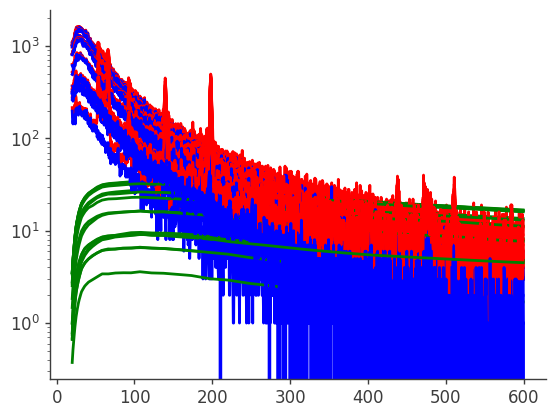

In [19]:
# difference between detectors of a single pointing

for index in range(0,19):

    plt.plot(energy_bins[:-1], total_counts[index], label='total counts pyspi', c='r')
    plt.plot(energy_bins[:-1], source_counts[index], label='source counts pyspi', c='b')
    plt.plot(energy_bins[:-1], spimodfit_counts_1160[index], c="g", label='source counts spimodfit')
    #plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
    plt.yscale('log')
    #plt.legend()

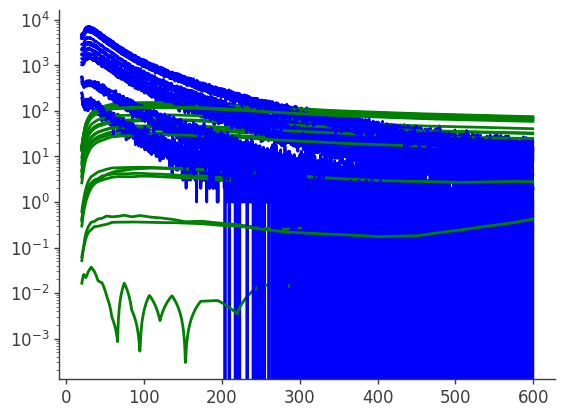

In [20]:
# difference between the same detector of different pointings for now the first 25

for index in range(0,25*85, 85):

    #plt.plot(energy_bins[:-1], total_counts[index], label='total counts pyspi', c='r')
    plt.plot(energy_bins[:-1], source_counts[index], label='source counts pyspi', c='b')
    plt.plot(energy_bins[:-1], spimodfit_counts_1160[index//85 * 19], c="g", label='source counts spimodfit')
    #plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
    plt.yscale('log')
    #plt.legend()

## Plot the spimodfit response

This is just the RMF, only Energy redistribution and no IRFs, so not angular resolved and thus the same for every detector of the pointings in this rev

Filename: /home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_normal_new/spectral_response.rmf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     50   2R x 9C   [8A, 32A, 1J, 1J, 256A, 3A, 1I, 1D, 1D]   
  2  SPI.-RMF.-RSP    1 BinTableHDU     46   206R x 6C   [1E, 1E, 1I, 1I, 1I, 1PE(41)]   
  3  SPI.-EBDS-SET    1 BinTableHDU     39   41R x 3C   [1J, 1E, 1E]   


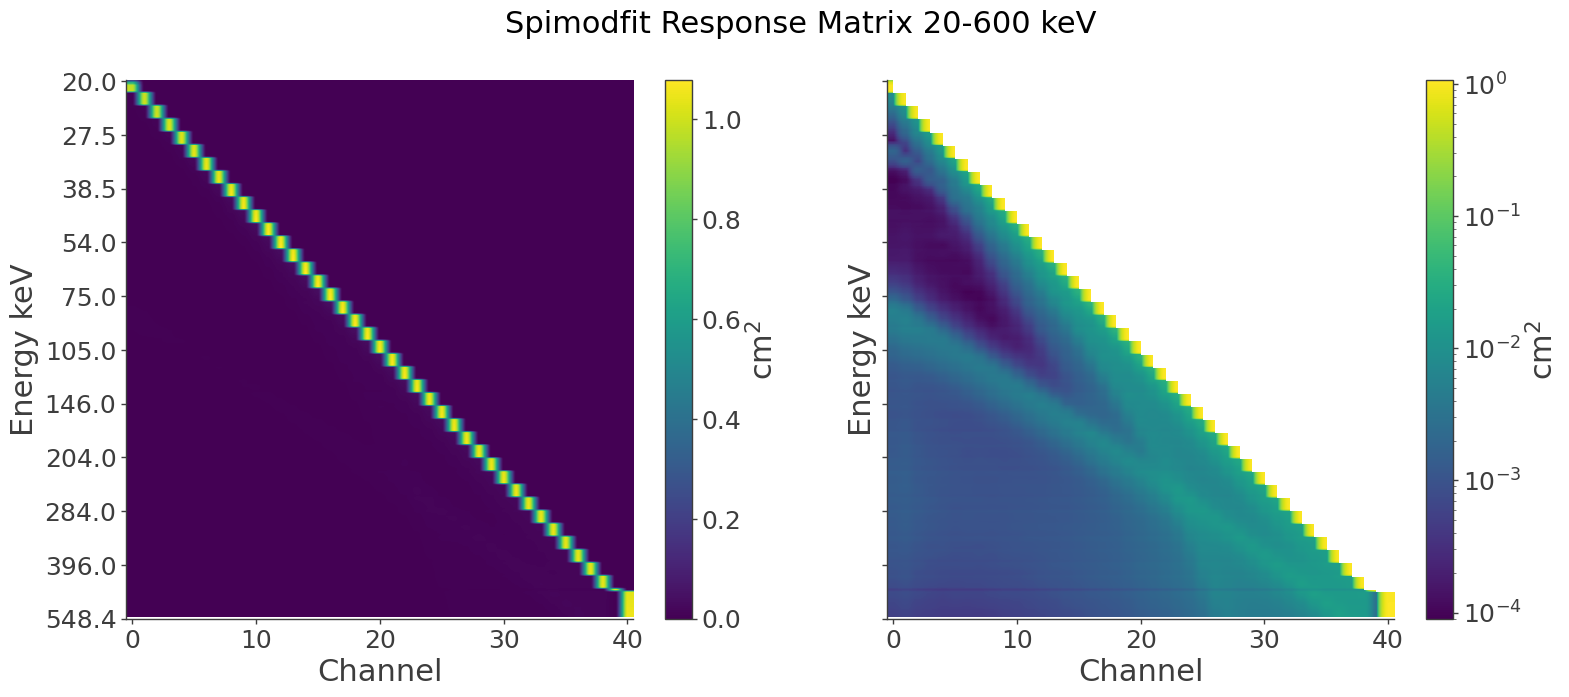

In [41]:
response_file = 'spectral_response.rmf.fits'

with fits.open(spimodfit_path_41 + response_file) as hdul:
    hdul.info()
    data = hdul[2].data
    t = Table(data)


energy_low = np.array(t["ENERG_LO"])
energy_low = np.append(energy_low, t["ENERG_HI"][-1])
matrix = t["MATRIX"]
len(matrix[-1])

response_matrix = np.zeros((len(matrix), len(matrix[-1])))
for i, m in enumerate(matrix):
    m_array = np.zeros(len(matrix[-1]))  # Create an array of zeros with length 41
    m_array[:len(m)] = m  # Copy the values of m into m_array
    response_matrix[i] = m_array  # Assign m_array to the response matrix

fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(response_matrix, origin='upper', cmap='viridis', aspect='auto')

plt.colorbar(im, label='cm$^2$')
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Energy keV")
ax[0].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])

response_matrix[response_matrix < 1e-7] = np.nan
ax[1].imshow(np.zeros_like(response_matrix), origin='upper', cmap='Greys', aspect='auto')
im = ax[1].imshow(response_matrix, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label='cm$^2$')
ax[1].set_xlabel("Channel")
ax[1].set_ylabel("Energy keV")
ax[1].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])

fig.suptitle("Spimodfit Response Matrix 20-600 keV")
fig.savefig("spimodfit_response_matrix.pdf")

## Pyspi Response

Text(0, 0.5, 'Energy keV')

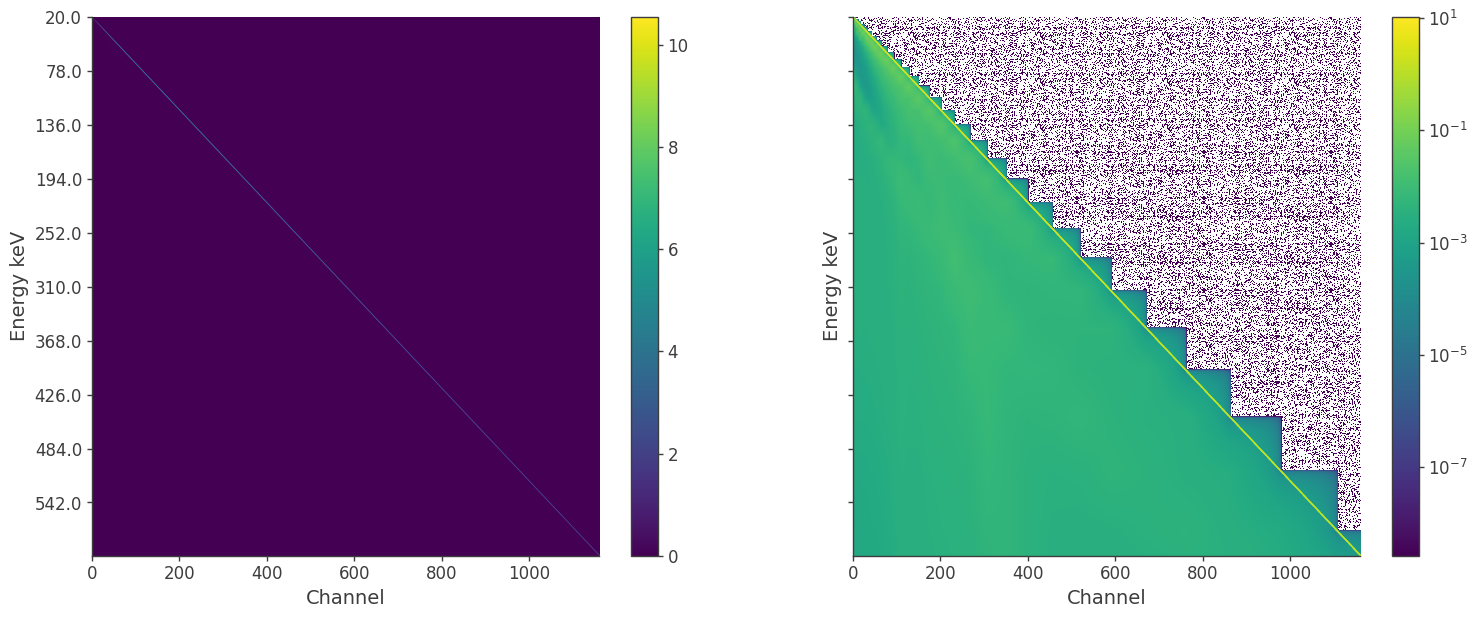

In [22]:
pyspi_response = res_1160[5][0]
energy_bins = res_1160[3]


fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(pyspi_response, origin='upper', cmap='viridis', aspect='auto')

plt.colorbar(im)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Energy keV")
ax[0].set_yticks(np.linspace(0, len(energy_bins), 11),  energy_bins[::int(np.floor(len(energy_bins)/10))])


im = ax[1].imshow(pyspi_response, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im)
ax[1].set_xlabel("Channel")
ax[1].set_ylabel("Energy keV")
#ax[1].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])


### pyspi response for all energies

In [4]:
orig_data_path = orig_data_path_41
with fits.open(f"{orig_data_path}/pointing.fits") as file:
        t = Table.read(file[1])
        
        pointings = np.array(t["PTID_SPI"])
        
        time_start = np.array(t["TSTART"]) + 2451544.5
        time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
        time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])

In [5]:
version = find_response_version(time_start[14])
rsp_base = ResponseDataRMF.from_version(version)

bins = np.geomspace(20, 1000, 101)
emod = np.geomspace(20, 1000, 101)
# bins = np.linspace(20, 1000, 100)
# emod = np.linspace(20, 1000, 100)
tick_labels = [f"{i:.0f}" for i in emod[::10]]
print(tick_labels)

RMF = ResponseRMFGenerator.from_time(time_start[14], 0, bins, emod, rsp_base)

Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
['20', '30', '44', '65', '96', '141', '209', '309', '457', '676', '1000']


In [6]:
sd = SPIDRM(RMF, ra, dec)
matrix = sd.matrix.T

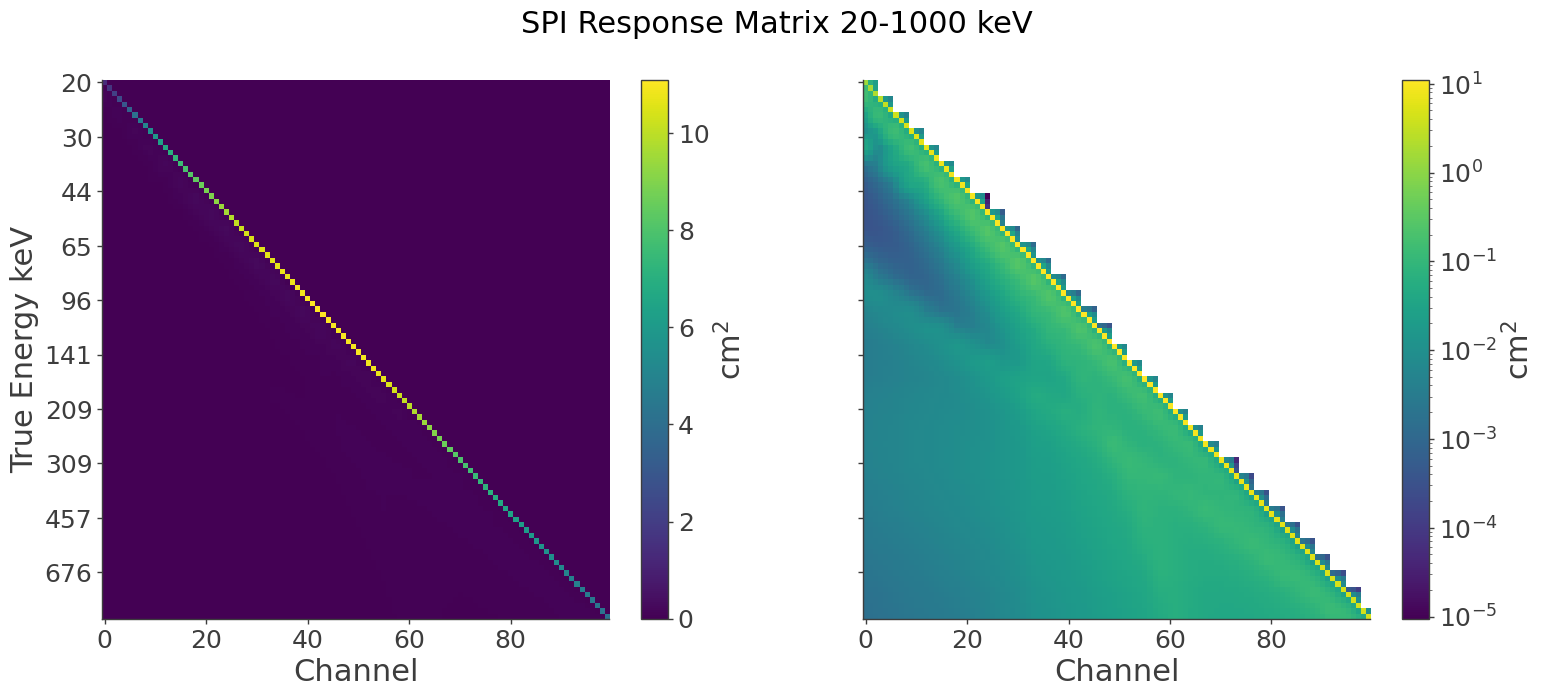

In [19]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18, 'axes.labelsize':22, 'xtick.labelsize':18, 'ytick.labelsize':18, 'legend.fontsize':18, 'figure.titlesize':22})
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(matrix, origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(im, label="cm$^2$")
ax[0].set_yticks(np.linspace(0, len(emod), len(tick_labels)),  tick_labels)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("True Energy keV")


im = ax[1].imshow(matrix, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label="cm$^2$")
ax[1].set_xlabel("Channel")
fig.suptitle("SPI Response Matrix 20-1000 keV")
fig.savefig("SPI_response_matrix.pdf")

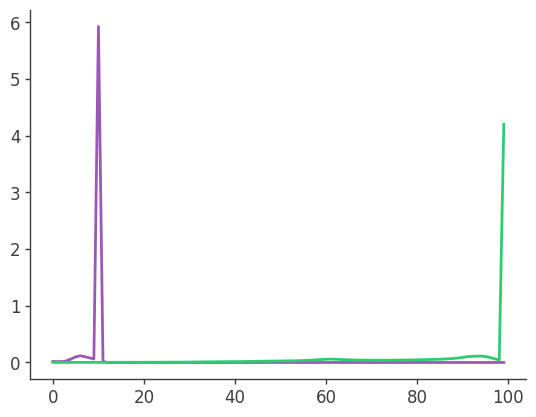

In [14]:
plt.plot(matrix[10])
plt.plot(matrix[-1])

In [42]:
np.linspace(0, len(emod), len(tick_labels))

array([  0. ,  10.1,  20.2,  30.3,  40.4,  50.5,  60.6,  70.7,  80.8,
        90.9, 101. ])